<a href="https://colab.research.google.com/github/rsaxby/dog-breed-classifier/blob/master/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from glob import glob
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torchvision
import torch.nn as nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch.optim as optim
from PIL import ImageFile

use_cuda = torch.cuda.is_available()
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My\ Drive/Colab\ Notebooks/data/dog-breed-classifier_data/

# list files in directory
#!ls

from datasets_and_dataloaders import *
from utils import *
from model_scratch import Net
from train import *
from predict import *

## Get the number of images and dog classes from the dataset

In [2]:
# load filenames for human and dog images
data_dir = '/content/drive/My Drive/Colab Notebooks/data/dog-breed-classifier_data/'

human_files = np.array(glob(data_dir+"humanImages/*/*"))
my_photos = np.array(glob(data_dir+"*.jpg"))
dog_files = np.array(glob(data_dir+"dogImages/*/*/*"))
dog_classes = np.array(glob(data_dir+"dogImages/train/*"))
num_dog_classes = len(dog_classes)
# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('There are %d total personal images.' % len(my_photos))
print('There are %d total dog classes.' % num_dog_classes)

There are 13233 total human images.
There are 8351 total dog images.
There are 2 total personal images.
There are 133 total dog classes.


## Create dataset and dataloaders



In [3]:
## Specify appropriate transforms, and batch_sizes
train_path = data_dir+"dogImages/train/"
valid_path = data_dir+"dogImages/valid/"
test_path = data_dir+"dogImages/test/"
batch_size = 32

# transforms
train_transforms = transforms.Compose([
    transforms.CenterCrop(350),
    transforms.RandomAffine(4, translate=(0.2,0.2), scale=None, shear=0.2, resample=False, fillcolor=0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225]) 
])
transforms_ = {'train':train_transforms, 'test':test_transforms}
directories = {'train':train_path, 'valid':valid_path, 'test':test_path}

# datasets
datasets_ = create_datasets(directories, transforms_, valid=True)

# dataloaders
dataloaders = create_dataloaders(datasets_, batch_size, shuffle=True)
train_dataloader = dataloaders['train']
valid_dataloader = dataloaders['valid']
test_dataloader = dataloaders['test']
dataset_sizes = {"train":len(train_dataloader), "valid":len(valid_dataloader), "test":len(test_dataloader)}
print(dataset_sizes)

{'train': 209, 'valid': 27, 'test': 27}


In [0]:
# create dog df
dog_images = create_dog_image_df(datasets_['train'], dog_files)

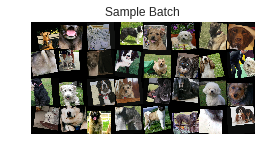

In [5]:
# print a sample batch to visualize transforms
# load truncated files
ImageFile.LOAD_TRUNCATED_IMAGES = True
dataiter = iter(train_dataloader)
images, sample_labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), title="Sample Batch")

##Create a CNN to Classify Dog Breeds (from Scratch)

In [10]:
# instantiate the CNN
model_scratch = Net(len(datasets_['train'].classes))
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
  device = 'cuda'
  model_scratch.cuda()

Net(
  (conv3_32): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32_64): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv64_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
)


In [0]:
# select loss function
criterion = nn.CrossEntropyLoss()
# select optimizer
optimizer = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.7)
# select scheduler
scheduler = lr_scheduler.StepLR(optimizer,step_size=25,gamma=0.1,last_epoch=-1)

Epoch 1/30
----------
train Loss: 155.2374 Acc: 0.0150
valid Loss: 146.2095 Acc: 0.0312

Epoch 2/30
----------
train Loss: 149.1017 Acc: 0.0274
valid Loss: 138.9260 Acc: 0.0370

Epoch 3/30
----------
train Loss: 144.5137 Acc: 0.0361
valid Loss: 135.9098 Acc: 0.0552

Epoch 4/30
----------
train Loss: 142.2291 Acc: 0.0418
valid Loss: 133.8352 Acc: 0.0532

Epoch 5/30
----------
train Loss: 139.0147 Acc: 0.0499
valid Loss: 132.2485 Acc: 0.0625

Epoch 6/30
----------
train Loss: 136.8146 Acc: 0.0591
valid Loss: 134.1387 Acc: 0.0544

Epoch 7/30
----------
train Loss: 134.8001 Acc: 0.0699
valid Loss: 128.7679 Acc: 0.0775

Epoch 8/30
----------
train Loss: 131.8408 Acc: 0.0789
valid Loss: 127.9954 Acc: 0.0764

Epoch 9/30
----------
train Loss: 129.1619 Acc: 0.0851
valid Loss: 126.5195 Acc: 0.0868

Epoch 10/30
----------
train Loss: 127.4012 Acc: 0.0954
valid Loss: 127.2018 Acc: 0.0764

Epoch 11/30
----------
train Loss: 125.0629 Acc: 0.1025
valid Loss: 124.9752 Acc: 0.1084

Epoch 12/30
-------

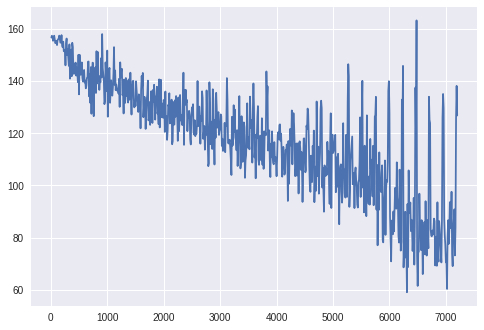

In [12]:
# train the model
model_scratch = train_model(dataloaders, dataset_sizes, model_scratch, criterion, optimizer 
                      , save_path='model_scratch.pt', scheduler=scheduler, device=device, num_epochs=30, plot=True)

In [13]:
# call test function 
ImageFile.LOAD_TRUNCATED_IMAGES = True
test(dataloaders, model_scratch, criterion, use_cuda)

Test Loss: 4.156946


Test Accuracy: 15% (129/836)


## Transfer Learning

In [6]:
## specify model architecture 
model_transfer = models.vgg16(pretrained=True)
print(model_transfer.classifier[6])
# freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
# replace classifier    
in_features = model_transfer.classifier[6].in_features 
out_features = len(datasets_['train'].classes)
print(out_features)
model_transfer.classifier[6] = nn.Sequential(nn.Linear(in_features, out_features))
# move tensors to GPU if CUDA is available
if use_cuda:
    model_transfer.cuda()
    device = 'cuda'

Linear(in_features=4096, out_features=1000, bias=True)
133


In [0]:
# select criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfer.classifier[6].parameters(), lr = 0.0003)
# select scheduler 
scheduler = lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1,last_epoch=-1)

In [20]:
# train the model
model_transfer = train_model(dataloaders, dataset_sizes, model_transfer, criterion, optimizer 
                      , save_path='model_transfer-vgg16-v1.pt', scheduler=scheduler, device=device, num_epochs=12, plot=False)

Epoch 1/12
----------
train Loss: 15.2603 Acc: 0.8467
valid Loss: 14.1371 Acc: 0.8507

Epoch 2/12
----------
train Loss: 14.7569 Acc: 0.8510
valid Loss: 14.6708 Acc: 0.8372

Epoch 3/12
----------
train Loss: 13.8523 Acc: 0.8615
valid Loss: 14.5399 Acc: 0.8542

Epoch 4/12
----------
train Loss: 13.6852 Acc: 0.8621
valid Loss: 14.6836 Acc: 0.8372

Epoch 5/12
----------
train Loss: 13.3264 Acc: 0.8600
valid Loss: 14.2745 Acc: 0.8295

Epoch 6/12
----------
train Loss: 13.0249 Acc: 0.8660
valid Loss: 14.2100 Acc: 0.8588

Epoch 7/12
----------
train Loss: 12.4199 Acc: 0.8691
valid Loss: 14.5202 Acc: 0.8441

Epoch 8/12
----------
train Loss: 11.1277 Acc: 0.8890
valid Loss: 14.0452 Acc: 0.8565

Epoch 9/12
----------
train Loss: 10.9275 Acc: 0.8909
valid Loss: 13.8972 Acc: 0.8511

Epoch 10/12
----------
train Loss: 10.7939 Acc: 0.8931
valid Loss: 13.8032 Acc: 0.8657

Epoch 11/12
----------
train Loss: 10.8930 Acc: 0.8946
valid Loss: 13.7647 Acc: 0.8646

Epoch 12/12
----------
train Loss: 10.701

In [21]:
# call test function 
ImageFile.LOAD_TRUNCATED_IMAGES = True
test(dataloaders, model_transfer, criterion, use_cuda)

Test Loss: 0.505042


Test Accuracy: 85% (713/836)


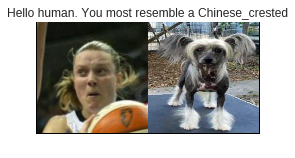

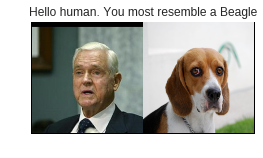

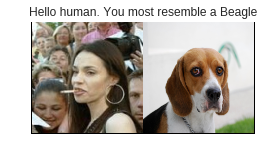

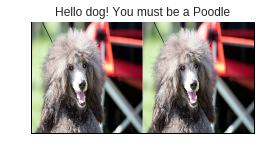

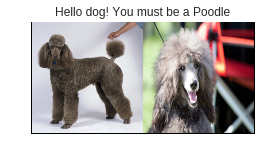

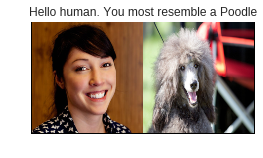

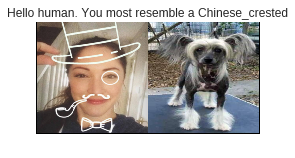

In [22]:
# list of class names by index
class_names = [item[4:].replace("_", " ") for item in datasets_['train'].classes]


## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:2], my_photos[:])):
    run_app(model_transfer, file, datasets_['train'].classes, dog_images, add_file_path=data_dir)
